# Weight erasure

You might have heard the claim that *"during training, the weights of a wide enough neural network move a vanishing distance from their initial values"*. For instance, [Lee et al. (2019)](https://arxiv.org/abs/1902.06720) suggest that wide enough neural networks never leave the linearization around their initial weights. And [Jesus et al. (2020)](https://arxiv.org/abs/2012.02550) conduct an intriguing experiment seemingly in support of this narrative. At initialization, they "watermark" one of the weight matrices with an image of the letter "a". They find that the "a" is still visible at the end of training (left) so long as the training does not diverge (right).

![Jesus et al. (2020)](assets/erasure.png)

In this notebook, we will investigate this phenomenon by replicating the experiment of [Jesus et al. (2020)](https://arxiv.org/abs/2012.02550). We will show that duality-based optimizers exhibit qualitatively different behaviour to what was reported: the initial weights are fully erased through the course of training. This lines up with the theoretical prediction that we made in our paper on [modular duality](https://arxiv.org/abs/2410.21265). At the end of the notebook, we will show how these results can be understood simply in terms of the "stable rank" of the weight updates.

I believe that this experiment underscores the importance of metrized deep learning for understanding the basic numerical properties of neural networks.

## Setup: Creating a watermark

To begin, we write a helper function to create a JAX array containing the letter "a" in a square matrix.

In [1]:
import jax.numpy as jnp
from PIL import Image, ImageDraw, ImageFont

def create_letter_matrix(size, letter='a', font_name="arial.ttf"):
    img = Image.new('L', (size, size), 255)
    draw = ImageDraw.Draw(img)

    font = ImageFont.truetype(font_name, size)
    
    bbox = draw.textbbox((0, 0), letter, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
    x = (size - text_width) // 2
    y = size // 2 - int(1.2 *text_height)
    
    draw.text((x, y), letter, fill=0, font=font)

    return jnp.array(img) / 255.0

Let's plot some of these matrices at different resolutions (i.e. matrix sizes).

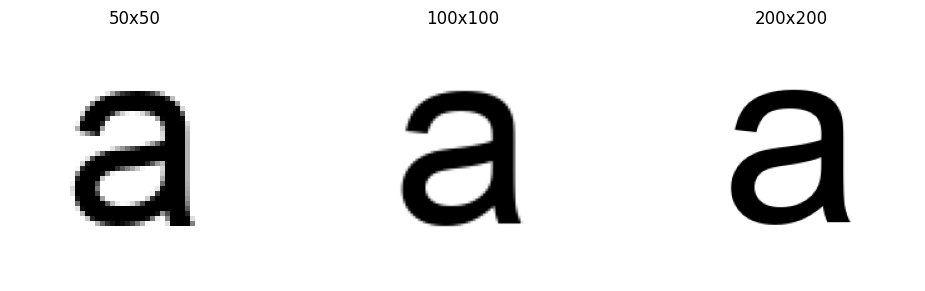

In [2]:
import matplotlib.pyplot as plt

# Create letter matrices at different resolutions
sizes = [50, 100, 200]
letter_matrices = [create_letter_matrix(size, letter='a') for size in sizes]

# Plot the matrices side by side
plt.figure(figsize=(10, 3))
for i, (size, matrix) in enumerate(zip(sizes, letter_matrices)):
    plt.subplot(1, 3, i+1)
    plt.imshow(matrix, cmap='gray')
    plt.title(f'{size}x{size}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Watermarking the initial weights

For our main experiment, we will train an MLP with watermarked weights on the CIFAR-10 dataset. Let's first download the data and define a function to get a batch of data.

In [14]:
import jax
from data.cifar10 import load_cifar10

train_images, train_labels, test_images, test_labels = load_cifar10()

one_hot = lambda x, k: jnp.array(x[:, None] == jnp.arange(k))
X_train = train_images.reshape(train_images.shape[0], -1)
y_train = one_hot(train_labels, 10)

def get_batch(key, batch_size):
    idx = jax.random.choice(key, X_train.shape[1], shape=(batch_size,))
    return X_train[idx, :], y_train[idx, :]

Next, let's define a function to create an MLP of a given shape.

In [15]:
import modula

def MLP(input_dim, output_dim, width):
    mlp =  modula.atom.Linear(output_dim, width)
    mlp @= modula.bond.ReLU() 
    mlp @= modula.atom.Linear(width, width)
    mlp @= modula.bond.ReLU() 
    mlp @= modula.atom.Linear(width, input_dim)

    mlp.jit()

    return mlp

And finally, let's watermark the initial weights of an MLP of width 1024.

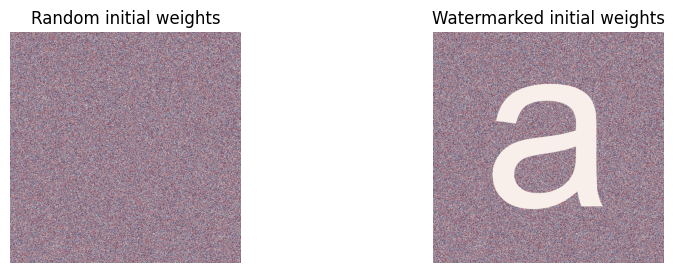

In [16]:
width = 1024
mlp = MLP(X_train.shape[1], y_train.shape[1], width)

key = jax.random.PRNGKey(0)
initial_w = mlp.initialize(key)

unmasked_initial_matrix = initial_w[1]
initial_w[1] = initial_w[1] * create_letter_matrix(initial_w[1].shape[0])
masked_initial_matrix = initial_w[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

vmin = jnp.min(unmasked_initial_matrix) / 4
vmax = jnp.max(unmasked_initial_matrix) / 4

ax1.imshow(unmasked_initial_matrix, cmap='RdBu', vmin=vmin, vmax=vmax)
ax1.set_title('Random initial weights')
ax1.axis('off')

ax2.imshow(masked_initial_matrix, cmap='RdBu', vmin=vmin, vmax=vmax) 
ax2.set_title('Watermarked initial weights')
ax2.axis('off')

plt.show()

## Running the experiment

First, we set up the training loop. We train for a given number of steps and record the loss and accuracy at each step, as well as the final weights. For non-dualized training, we spectrally normalize the gradient updates. This means that for a given learning rate, the weight updates have the same spectral norm in both dualized and non-dualized training. This makes the results easier to interpret, but you can check that disabling the spectral normalization does not change the qualitative findings.

In [17]:
def spec_norm(M, num_steps=20):
    v = jax.random.normal(jax.random.PRNGKey(0), (M.shape[1],))
    
    for _ in range(num_steps):
        u = M @ v
        u = u / jnp.linalg.norm(u)
        v = M.T @ u 
        v = v / jnp.linalg.norm(v)
    
    return jnp.linalg.norm(M @ v)

def train(module, w, steps, lr, batch_size, dualize=True):

    losses = []
    accuracies = []

    def eval(w, inputs, targets):
        outputs = module(inputs, w)
        loss = ((outputs-targets) ** 2).mean()
        acc = jnp.mean(jnp.argmax(outputs, axis=0) == jnp.argmax(targets, axis=0))
        return loss, acc

    eval_and_grad = jax.jit(jax.value_and_grad(eval, has_aux=True))

    for step in range(steps):
        key = jax.random.PRNGKey(step)
        inputs, targets = get_batch(key, batch_size)

        (loss, acc), grad_w = eval_and_grad(w, inputs, targets)

        if dualize:
            d_w = module.dualize(grad_w)
        else:
            # divide by 3 since module.dualize also does so for 3 layer MLP
            d_w = [g / spec_norm(g) / 3 * jnp.sqrt(g.shape[0]/g.shape[1]) for g in grad_w]

        w = [weight - lr * d_weight for weight, d_weight in zip(w, d_w)]

        losses.append(loss)
        accuracies.append(acc)

        if jnp.all(jnp.isfinite(w[1])):
            final_w = w
    
    return final_w, jnp.array(losses), jnp.array(accuracies)

We now run this loop for a range of learning rates with dualization both enabled and disabled.

In [ ]:
from tqdm.notebook import tqdm

batch_size = 1024
steps = 1001

lr_list = [2**i for i in range(-6,4)]

results = {}

for dualize in [True, False]:
    print("Running experiments with dualize =", dualize)
    for lr in tqdm(lr_list):
        final_w, losses, accs = train(mlp, initial_w, steps, lr, batch_size, dualize)
        results[dualize, lr] = (final_w, losses, accs)

Running experiments with dualize = True


  0%|          | 0/10 [00:00<?, ?it/s]

And finally, we plot the results. For each learning rate, we plot the final training accuracy (averaged over the last 50 steps). And we overlay the image of the final weight matrix for each point on the plot.

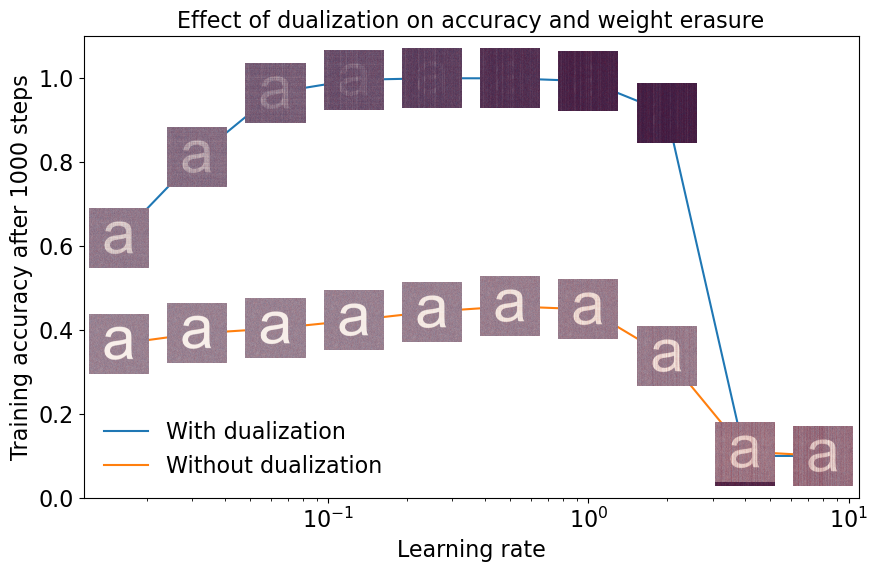

In [8]:
# Extract final accuracies and weights for each learning rate and dualize setting
final_accs_dual = [jnp.mean(results[True, lr][2][-50:]) for lr in lr_list]
final_accs_nodual = [jnp.mean(results[False, lr][2][-50:]) for lr in lr_list]
final_weights_dual = [results[True, lr][0][1] for lr in lr_list]
final_weights_nodual = [results[False, lr][0][1] for lr in lr_list]

# Create figure with two subplots - main plot and small weight matrices
fig = plt.figure(figsize=(10, 6))
main_ax = plt.gca()

# Plot main accuracy curves
main_ax.plot(lr_list, final_accs_dual, label='With dualization')
main_ax.plot(lr_list, final_accs_nodual, label='Without dualization')
main_ax.set_xscale('log')
main_ax.set_ylim(0.0, 1.1)

# Add small weight matrix plots at each point
for i, (lr, acc) in enumerate(zip(lr_list, final_accs_dual)):
    lr_disp, acc_disp = main_ax.transData.transform((lr, acc))
    lr_fig, acc_fig = fig.transFigure.inverted().transform((lr_disp, acc_disp))
    inset = fig.add_axes([lr_fig - 0.05, acc_fig - 0.05, 0.1, 0.1])
    inset.imshow(final_weights_dual[i], cmap='RdBu', vmin=vmin, vmax=vmax)
    inset.axis('off')

for i, (lr, acc) in enumerate(zip(lr_list, final_accs_nodual)):
    lr_disp, acc_disp = main_ax.transData.transform((lr, acc))
    lr_fig, acc_fig = fig.transFigure.inverted().transform((lr_disp, acc_disp))
    inset = fig.add_axes([lr_fig - 0.05, acc_fig - 0.05, 0.1, 0.1])
    inset.imshow(final_weights_nodual[i], cmap='RdBu', vmin=vmin, vmax=vmax)
    inset.axis('off')

main_ax.set_xlabel('Learning rate')
main_ax.set_ylabel('Training accuracy after 1000 steps')
main_ax.set_title('Effect of dualization on accuracy and weight erasure')

plt.rcParams.update({'font.size': 16})
main_ax.tick_params(labelsize=16)
main_ax.xaxis.label.set_size(16)
main_ax.yaxis.label.set_size(16)
main_ax.title.set_size(16)
main_ax.legend(loc='lower left', frameon=False, fontsize=16)

plt.show()

We make three main observations from this plot:
1. The network reaches a significantly higher training accuracy with dualization than without.
2. With dualization, the letter "a" is completely erased at the maximum stable learning rate.
3. Without dualization, the letter "a" is not erased, even at the maximum stable learning rate.

In short, not only do duality-based optimizers train faster, but they also operate in a qualitatively different numerical regime. Unlike for standard gradient descent---or in this case spectrally normalized gradient descent---the weights evolve in a way that is visible to the human eye.


## Interpretation via the stable rank

We can understand the results from the previous section by considering the stable rank of the weight updates. The stable rank of a matrix $M\in\mathbb{R}^{m\times n}$ is defined to be the ratio of the squared Frobenius norm to the squared spectral norm:

$$ \operatorname{srank}M := \frac{\|M\|_F^2}{\|M\|_*^2}.$$

This quantity is important for our discussion because we can characterize the size of the entries of a matrix in terms of the stable rank of the matrix and the spectral norm of the matrix:

$$\textrm{average entry size of } M = \frac{\|M\|_F}{\sqrt{mn}} = \sqrt{\frac{\operatorname{srank}M}{mn}} \times \|M\|_*.$$

So, for two weight updates of the same spectral norm, the amount that the weight entries move will vary depending on the stable rank of the weight update. Our claim is basically that: 
- raw gradients tend to have very small stable rank,
- dualized gradients tend to have high stable rank,

and this explains the difference in erasure between gradient descent and dualized gradient descent. In fact, this theoretical observation is what made us think of running this experiment in the first place.

To understand the source of the difference in stable rank between gradients and dualized gradients, we need to think about what the duality map for linear layers actually does to the gradient matrix. The duality map takes any non-zero singular value of the gradient matrix and sets it to 1. This operation inflates the stable rank of the gradient matrix to equal the rank---to check this, you'll need the alternative formula for the stable rank: $\operatorname{srank}M = \sum_i \sigma_i^2 / \max_i \sigma_i^2$, where the $\{\sigma_i\}$ are the singular values.

To test this claim, let's measure the stable rank of gradients and dualized gradients at a range of widths:

In [9]:
import matplotlib.pyplot as plt

stable_rank_grads = []
stable_rank_dualized_grads = []

srank = lambda x: jnp.linalg.norm(x, ord='fro')**2 / jnp.linalg.norm(x, ord=2)**2

widths = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
batch_size = 512

for width in widths:
    mlp = MLP(X_train.shape[1], y_train.shape[1], width)
    key = jax.random.PRNGKey(0)
    w = mlp.initialize(key)

    inputs, targets = get_batch(key, batch_size)
    loss = lambda w: ((mlp(inputs, w)-targets) ** 2).mean()
    grad_w = jax.grad(loss)(w)
    d_w = mlp.dualize(grad_w)

    stable_rank_grads.append(srank(grad_w[1]))
    stable_rank_dualized_grads.append(srank(d_w[1]))

And let's plot the results:

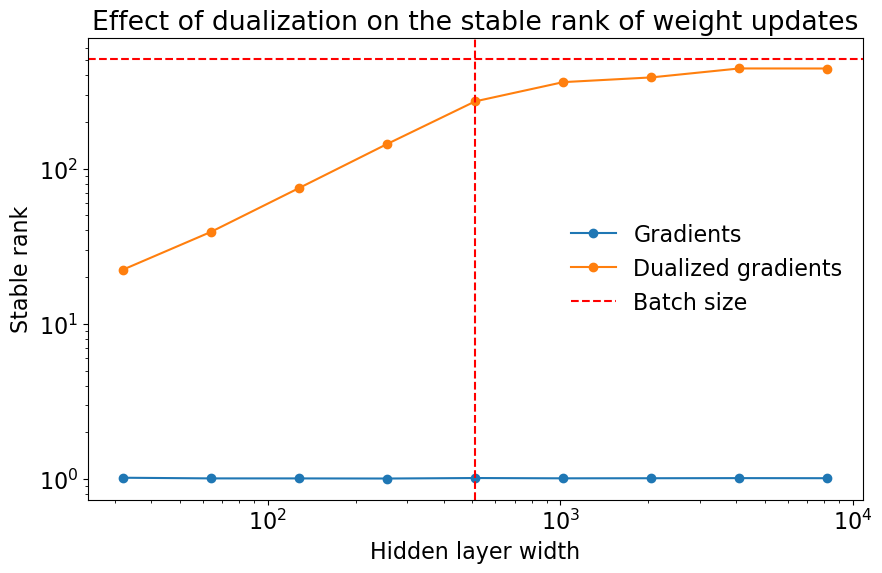

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(widths, stable_rank_grads, 'o-', label='Gradients')
plt.plot(widths, stable_rank_dualized_grads, 'o-', label='Dualized gradients')
plt.axvline(x=batch_size, color='r', linestyle='--', label='Batch size')
plt.axhline(y=batch_size, color='r', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hidden layer width')
plt.ylabel('Stable rank')
plt.legend(frameon=False, loc='right')
plt.title('Effect of dualization on the stable rank of weight updates')
plt.show()

As we can see, the stable rank of the gradients is very small at all widths. Meanwhile, the stable rank of the dualized gradients increases with width until the width reaches the batch size, at which point it plateaus. This is expected because the rank of the gradients is capped by the batch size, and dualization cannot inflate the stable rank beyond the rank itself.

## Conclusion

In this notebook, we have shown that duality-based optimizers exhibit qualitatively different numerical behaviour to standard gradient descent. When training a width 1024 neural network with vanilla gradient descent, the weights hardly move at all from their initial values. But when training with dualized gradient descent, the weights move substantially in a way that is visible to the human eye. This underscores the importance of metrized deep learning for understanding basic numerical properties of neural networks.

## Acknowledgements

I became aware of the weight erasure experiment of [Jesus et al. (2020)](https://arxiv.org/abs/2012.02550) thanks to [a tweet](https://x.com/norabelrose/status/1844768462717292980) of Nora Belrose. Tongzhou Wang ran some [initial experiments](https://x.com/ssnl_tz/status/1845179813755224406) on this question after [I tweeted about it](https://x.com/jxbz/status/1845146670365016427).